In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arch
import scipy
from arch.univariate import GARCH, EWMAVariance
import warnings
warnings.filterwarnings('ignore')

In [85]:
descriptions = pd.read_excel('barnstable_analysis_data.xlsx',sheet_name = 'descriptions',index_col=0)
data = pd.read_excel('barnstable_analysis_data.xlsx',sheet_name = 'data',index_col=0) 
data.head() 

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033296,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


In [86]:
excess_return = data['SPX'] - data['TB1M']
excess_return.dropna(inplace=True)
excess_return.head()

date
1926-01-30   -0.004844
1926-02-27   -0.035908
1926-03-31   -0.060309
1926-04-30    0.036252
1926-05-28    0.010932
dtype: float64

Text(0, 0.5, 'Return Rate')

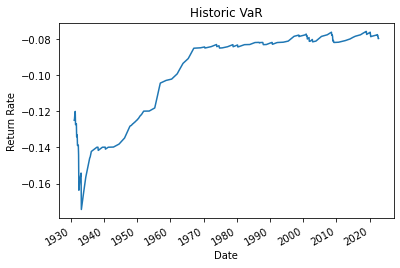

In [87]:
var = excess_return.expanding().quantile(.05, axis=0).shift(1)
hist_var = var[60:]
hist_var.plot() 
plt.title("Historic VaR")
plt.xlabel("Date")
plt.ylabel("Return Rate") 

In [88]:
excess_ret_61 = excess_return[60:]
VaR_periods = excess_ret_61[excess_ret_61 < hist_var].dropna()
freq = VaR_periods.shape[0] / excess_ret_61.shape[0]
freq
excess_ret_61.head()

date
1931-01-31    0.058494
1931-02-28    0.109674
1931-03-31   -0.069678
1931-04-30   -0.093632
1931-05-29   -0.138139
dtype: float64

## good

In [95]:
vol = excess_return.expanding(min_periods=60).std().to_frame('Expanding').shift(1).dropna()
vol['Rolling'] = excess_return.rolling(60, min_periods=60).std().shift(1)
vol.head()

,Expanding,Rolling
date,,
1931-01-31,0.060436,0.060436
1931-02-28,0.060322,0.060815
1931-03-31,0.061263,0.062008
1931-04-30,0.061539,0.062195
1931-05-29,0.062312,0.063452


,Expanding,Rolling
date,,
1931-01-31,-0.099720,-0.099720
1931-02-28,-0.099531,-0.100344
1931-03-31,-0.101083,-0.102313
1931-04-30,-0.101539,-0.102622
1931-05-29,-0.102815,-0.104695


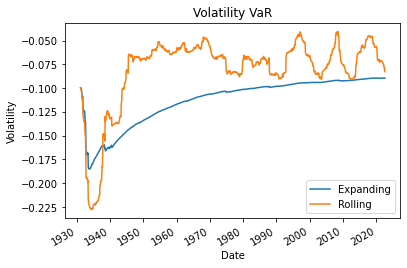

In [90]:
var_vol = (-1.65*vol['Expanding Series']).to_frame('Expanding') 
var_vol['Rolling'] = -1.65*vol['Rolling Window'] 
var_vol.plot() 
plt.title('Volatility VaR') 
plt.xlabel("Date")
plt.ylabel("Volatility") 
var_vol.head()

In [91]:
expanding = var_vol['Expanding']
rolling = var_vol['Rolling'] 
freq_exp = excess_ret_61[excess_ret_61 < expanding].shape[0] / excess_ret_61.shape[0] 
freq_roll = excess_ret_61[excess_ret_61 < rolling].shape[0] / excess_ret_61.shape[0] 
freq_table = pd.DataFrame([freq], index=['Frequency'], columns=['Empirical']) 
freq_table['Expanding'] = freq_exp 
freq_table['Rolling'] = freq_roll 
freq_table

,Empirical,Expanding,Rolling
Frequency,0.030331,0.017463,0.053309


<AxesSubplot:xlabel='date'>

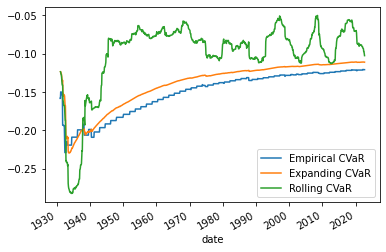

In [103]:
def cvar(data):
    quantile = data.quantile(0.05)
    return data[data < quantile].mean()
cvar_table = excess_return.expanding(min_periods=60).apply(cvar).to_frame('Empirical CVaR')
normal_5_pdf = scipy.stats.norm().pdf(-1.65)
cvar_table['Expanding CVaR'] = -normal_5_pdf/0.05*vol['Expanding']
cvar_table['Rolling CVaR'] = -normal_5_pdf/0.05*vol['Rolling']
cvar_table.dropna()
cvar_table.plot() 

,Empirical
Frequency,0.0
